In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv', low_memory=False)
test_df = pd.read_csv('test.csv', low_memory=False)

In [123]:
store_df = pd.read_csv('store.csv')

In [4]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
train_df.shape

(1017209, 9)

1. 1115 unique stores. All stores listed in a test set are listed in a train set. Although train set contains extra stores
2. There are only 1 record per 1 date. (Store, Date) is a unique identifier
3. History of sells contain 941 days (except 1 store). Start date 2013-01-01 (2013-01-02) and end date 2015-07-31
   Based on 941 records of sells it's needed to make predictions for the next 47 days
4. Missing values in test 'Open'. No pattern, fill with previous value
6. Almost 17% of sell records are 0s. Handle it. Provide test results for normal distribution
5. Fill in missing values. Competition – info is absent|no competitors. Promo2SinceWeek/Year - Promo2 explains 


In [6]:
#1.
train_df['Store'].nunique()

1115

In [7]:
test_df['Store'].nunique()

856

In [8]:
set(test_df['Store']) - set(train_df['Store'])

set()

In [9]:
len(set(train_df['Store']) - set(test_df['Store']))

259

In [10]:
#2.
train_df.groupby(['Store', 'Date']).size().apply(lambda x: x>1).any()

False

In [11]:
#3.
train_df['Date'] = pd.to_datetime(train_df['Date'], infer_datetime_format=True)
test_df['Date'] = pd.to_datetime(test_df['Date'], infer_datetime_format=True)

In [12]:
train_df.groupby('Store')['Date'].apply(lambda x: (x.max() - x.min()).days).value_counts()

941    1114
940       1
Name: Date, dtype: int64

In [13]:
train_df.groupby('Store')['Date'].min().value_counts()

2013-01-01    1114
2013-01-02       1
Name: Date, dtype: int64

In [14]:
train_df.groupby('Store')['Date'].max().value_counts()

2015-07-31    1115
Name: Date, dtype: int64

In [15]:
test_df.groupby('Store')['Date'].apply(lambda x: (x.max() - x.min()).days).value_counts()

47    856
Name: Date, dtype: int64

In [16]:
test_df.groupby('Store')['Date'].min().value_counts()

2015-08-01    856
Name: Date, dtype: int64

In [17]:
test_df.groupby('Store')['Date'].max().value_counts()

2015-09-17    856
Name: Date, dtype: int64

In [18]:
train_df = train_df.set_index('Date')
test_df = test_df.set_index('Date')

In [21]:
train_df.sort_index(inplace=True)

In [22]:
test_df.sort_index(inplace=True)

In [23]:
#4.
train_df.isna().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [24]:
test_df.isna().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [48]:
# there is no pattern in 'Open' missing values,that's why we can fill it with the previous value
test_df['Open'] = test_df.groupby('Store')['Open'].ffill()

In [153]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,NaN
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,NaN


In [95]:
set(store_df['Store']) - set(train_df['Store']) 

set()

In [96]:
set(train_df['Store']) - set(store_df['Store']) 

set()

In [98]:
store_df['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [100]:
store_df['Assortment'].value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [101]:
store_df.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [104]:
store_df[store_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [128]:
#5.
subset=['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
store_df[subset] = store_df[subset].fillna(0)

In [136]:
subset = ['Promo2SinceWeek', 'Promo2SinceYear']
store_df.groupby('Promo2').apply(lambda x: x[subset].isna().sum())

,Promo2SinceWeek,Promo2SinceYear
Promo2,,
0,544,544
1,0,0


In [137]:
store_df[subset] = store_df[subset].fillna(0)

In [140]:
store_df['Promo2SinceYear'].value_counts()

0.0       544
2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

In [ ]:
#6.

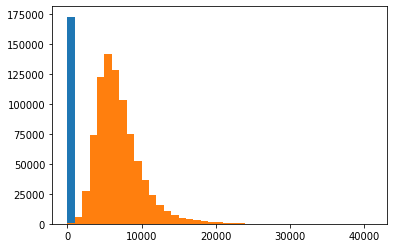

In [164]:
plt.hist(train_df[train_df['Open'] == 0]['Sales'], bins=np.arange(train_df['Sales'].min(), train_df['Sales'].max(), step=1000))
plt.hist(train_df[train_df['Open'] == 1]['Sales'], bins=np.arange(train_df['Sales'].min(), train_df['Sales'].max(), step=1000))
plt.show()

In [165]:
train_df.groupby('Open').apply(lambda x: sum(x['Sales'] == 0))

Open
0    172817
1        54
dtype: int64

In [159]:
sum(train_df['Sales'] == 0) / train_df.shape[0]

0.16994639253093513

In [ ]:
# Sales are 0 almost always because stores are closed. Drop 0s if store is closed, fill sales 0 in test if store is closed.

In [59]:
# 10.
short_history_stores = train_df.groupby('Store').size()[train_df.groupby('Store').size().apply(lambda x: x<942)].index.tolist()

In [61]:
train_df[train_df['Store'].isin(short_history_stores)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,365,2,0,0,0,0,a,1
2013-01-01,413,2,0,0,0,0,a,1
2013-01-01,412,2,0,0,0,0,a,1
2013-01-01,407,2,0,0,0,0,a,1
2013-01-01,399,2,0,0,0,0,a,1
...,...,...,...,...,...,...,...,...
2015-07-31,712,5,7421,653,1,1,0,0
2015-07-31,750,5,6395,499,1,1,0,0
2015-07-31,736,5,5942,541,1,1,0,0
